# 04: Feature engineering and ASI calculation

This notebook turns raw indicators into three stress signals and then combines them into the Affordability Stress Index (ASI). The ASI is a relative score: higher values mean more renter pressure compared with other metros in the same run.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load processed data

Read the cleaned, merged dataset from `data/processed/`.

In [17]:
# Load the cleaned data
# df = pd.read_csv('../data/processed/metros_master.csv')

## Feature engineering

We create three signals that are easy to explain:
- Rent-to-income: how much of monthly income goes to rent.
- Rent growth: how fast rent is rising year over year.
- Vacancy stress: low vacancy means tight supply, so we flip the vacancy rate.

Each signal is scaled so metros can be compared on the same scale before we combine them.

In [18]:
from pathlib import Path

FEATURES_PATH = Path("data/processed/features_scaled.csv")
features_df = pd.read_csv(FEATURES_PATH)

feature_catalog = pd.DataFrame(
    [
        {
            "feature": "rent_to_income",
            "definition": "Avg 2BR rent ÷ monthly median after-tax income",
            "direction": "Higher = more stress",
            "scaled_column": "rent_to_income_scaled",
        },
        {
            "feature": "rent_growth_yoy",
            "definition": "Year-over-year % change in CMHC 2BR rent",
            "direction": "Higher = more stress",
            "scaled_column": "rent_growth_yoy_scaled",
        },
        {
            "feature": "vacancy_stress",
            "definition": "Negative CMHC vacancy rate (low vacancy ↦ stress)",
            "direction": "Higher = more stress",
            "scaled_column": "vacancy_stress_scaled",
        },
    ]
)

print(f"Loaded {len(features_df):,} metro-year observations from {FEATURES_PATH}")
feature_catalog

Loaded 41 metro-year observations from data/processed/features_scaled.csv


,feature,definition,direction,scaled_column
0,rent_to_income,Avg 2BR rent ÷ monthly median after-tax income,Higher = more stress,rent_to_income_scaled
1,rent_growth_yoy,Year-over-year % change in CMHC 2BR rent,Higher = more stress,rent_growth_yoy_scaled
2,vacancy_stress,Negative CMHC vacancy rate (low vacancy ↦ stress),Higher = more stress,vacancy_stress_scaled


In [19]:
raw_cols = ["rent_to_income", "rent_growth_yoy", "vacancy_rate", "vacancy_stress"]
scaled_cols = [f"{col}_scaled" for col in ["rent_to_income", "rent_growth_yoy", "vacancy_stress"]]

summary = (
    features_df[raw_cols + scaled_cols]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .T
    .loc[:, ["mean", "std", "25%", "50%", "75%"]]
    .round(3)
)

summary

,mean,std,25%,50%,75%
rent_to_income,0.367,0.076,0.316,0.342,0.399
rent_growth_yoy,5.002,2.136,3.500,4.900,6.225
vacancy_rate,3.156,1.023,2.700,3.100,3.700
vacancy_stress,-3.156,1.023,-3.700,-3.100,-2.700
rent_to_income_scaled,0.300,0.921,-0.314,-0.000,0.686
rent_growth_yoy_scaled,0.037,0.784,-0.514,-0.000,0.486
vacancy_stress_scaled,-0.056,1.023,-0.600,0.000,0.400


## Calculate Affordability Stress Index (ASI)

We average the three scaled signals (with equal weights by default). The output is one score per metro. A higher score means more stress.

In [20]:
# Compute ASI scores using the shared script
!.venv/bin/python src/compute_asi.py \
    --input data/processed/features_scaled.csv \
    --output data/processed/asi_scores.csv \
    --plot-output report/figures/asi_top15.png


### Inspect top and bottom metros
The ASI export is easier to sanity-check when we look at the highest and lowest stress metros side by side.

In [21]:
from pathlib import Path
from IPython.display import display
import pandas as pd


ASI_PATH = Path("data/processed/asi_scores.csv")
asi_df = pd.read_csv(ASI_PATH)
asi_df["asi_score"] = pd.to_numeric(asi_df["asi_score"], errors="coerce")
rank_cols = [col for col in ["metro_name_std", "metro_id", "year", "asi_score"] if col in asi_df.columns]
ranked = asi_df.dropna(subset=["asi_score"]).loc[:, rank_cols]

summary_tables = {
    "Top 15 (most stress)": ranked.sort_values("asi_score", ascending=False).head(15),
    "Bottom 15 (least stress)": ranked.sort_values("asi_score", ascending=True).head(15),
}

for title, table in summary_tables.items():
    print(title)
    display(table.reset_index(drop=True))
    print("\n")

Top 15 (most stress)


,metro_name_std,metro_id,asi_score
0,Saguenay,3408,2.000917
1,Greater Sudbury,3580,1.900000
2,Kamloops,3925,1.900000
3,Drummondville,3447,1.300000
4,Halifax,3205,0.773185
5,Saint John,3310,0.765138
6,Victoria,3935,0.724504
7,Sherbrooke,3433,0.633648
8,Trois-Rivières,3442,0.511927
9,St. John's,3001,0.496446




Bottom 15 (least stress)


,metro_name_std,metro_id,asi_score
0,Kelowna,3915,-2.108716
1,Calgary,3825,-1.109979
2,Barrie,3568,-0.710092
3,Edmonton,3835,-0.666105
4,Hamilton,3537,-0.522352
5,Moncton,3305,-0.436697
6,Oshawa,3532,-0.433106
7,Brantford,3543,-0.400000
8,Lethbridge,3810,-0.369725
9,Ottawa-Gatineau,3505,-0.322310


### Plot the lowest-stress metros
A simple bar chart of the 15 lowest ASI scores highlights where vacancy slack and slower rent growth still provide relief.

/var/folders/sv/8qrp9kb16sjbbcys97bsvg900000gn/T/ipykernel_3527/3967338776.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="asi_score", y="label", palette=["#2e7f62"])
/var/folders/sv/8qrp9kb16sjbbcys97bsvg900000gn/T/ipykernel_3527/3967338776.py:10: UserWarning: 
The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=plot_df, x="asi_score", y="label", palette=["#2e7f62"])


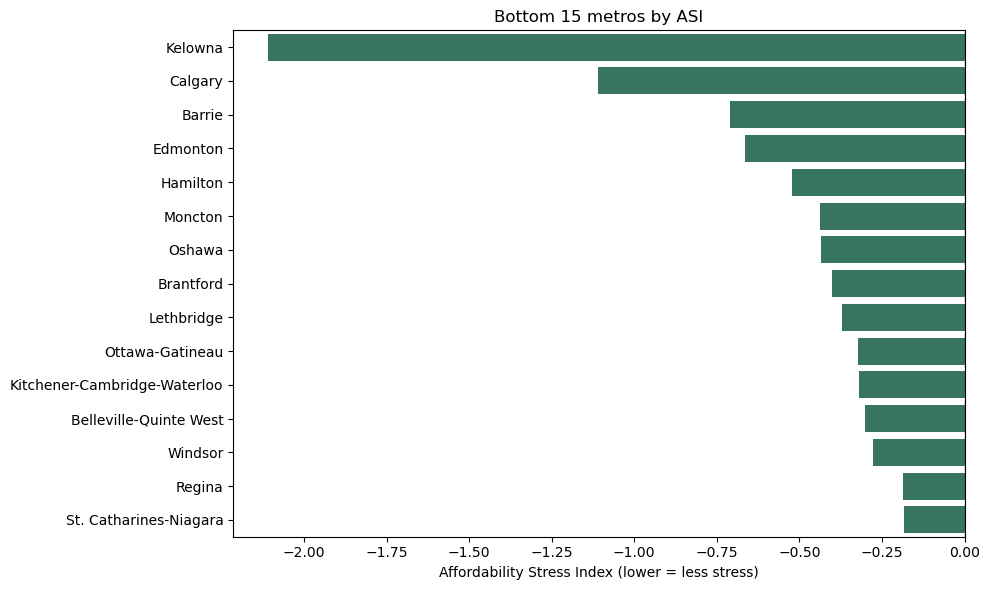

Saved bottom-15 chart to report/figures/asi_bottom15.png


In [22]:
if "ranked" not in globals():
    raise RuntimeError("Run the ranking cell above before plotting the bottom metros.")

bottom15 = ranked.sort_values("asi_score", ascending=True).head(15).copy()
label_col = "metro_name_std" if "metro_name_std" in bottom15.columns else "metro_id"
bottom15["label"] = bottom15[label_col].fillna(bottom15.get("metro_id"))
plot_df = bottom15.sort_values("asi_score", ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x="asi_score", y="label", palette=["#2e7f62"])
plt.xlabel("Affordability Stress Index (lower = less stress)")
plt.ylabel("")
plt.title("Bottom 15 metros by ASI")
plt.axvline(0, color="#555555", linestyle="--", linewidth=1)
plt.tight_layout()

output_path = Path("report/figures/asi_bottom15.png")
output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, dpi=200)
plt.show()

print(f"Saved bottom-15 chart to {output_path}")

## Visualize index distribution

A quick plot shows the spread of ASI scores across metros. This is descriptive only; it does not explain the causes.

In [23]:
# Create visualizations of the ASI scores
# plt.figure(figsize=(10, 6))
# plt.hist(df['asi_score'], bins=30)
# plt.xlabel('ASI Score')
# plt.ylabel('Frequency')
# plt.title('Distribution of Affordability Stress Index')
# plt.savefig('../report/figures/asi_distribution.png', dpi=300, bbox_inches='tight')

## Save ASI scores

Write the scores to `data/processed/asi_scores.csv` for later notebooks and reports.

In [24]:
# Outputs written by the script:
# - ../data/processed/asi_scores.csv
# - ../data/processed/asi_top15.png
